In [1]:
%matplotlib inline
import pylab
import pandas as pd

## load mapping summary CSVs and gather CSV

In [2]:
sample_id = 'p8808mo9'

# load mapping CSVs
all_df = pd.read_csv(f'outputs/minimap/depth/{sample_id}.summary.csv')
left_df = pd.read_csv(f'outputs/leftover/depth/{sample_id}.summary.csv')

# load gather CSV
gather_df = pd.read_csv(f'outputs/{sample_id}.gather.csv')

# connect gather_df to all_df and left_df using 'genome_id'
def fix_name(x):
    return "_".join(x.split('_')[:2]).split('.')[0]

gather_df['genome_id'] = gather_df['name'].apply(fix_name)

In [3]:
# CTB bug FIXME
# this ensures that only rows that share genome_id are in all the dataframes
in_gather = set(gather_df.genome_id)
in_left = set(left_df.genome_id)

in_both = in_left.intersection(in_gather)

all_df = all_df[all_df.genome_id.isin(in_both)]
left_df = left_df[left_df.genome_id.isin(in_both)]
gather_df = gather_df[gather_df.genome_id.isin(in_both)]

# reassign index now that we've maybe dropped rows
all_df.index = range(len(all_df))
left_df.index = range(len(left_df))
gather_df.index = range(len(gather_df))

assert len(all_df) == len(gather_df)
assert len(left_df) == len(gather_df)

In [4]:
# re-sort left_df and all_df to match gather_df order, using matching genome_id column
all_df.set_index("genome_id")
all_df.reindex(index=gather_df["genome_id"])
all_df.reset_index()
all_df[:3]

left_df.set_index("genome_id")
left_df.reindex(index=gather_df["genome_id"])
left_df.reset_index()
left_df[:3]

left_df["mapped_bp"] = (1 - left_df["percent missed"]/100) * left_df["genome bp"]

In [5]:
left_df[:5]

,Unnamed: 0,genome bp,missed,percent missed,coverage,genome_id,sample_id,mapped_bp
0,GCA_013302085,4418806,3758034,85.046368,0.682209,GCA_013302085,p8808mo9,660772.0
1,GCA_013301105,3895530,552288,14.177480,8.278217,GCA_013301105,p8808mo9,3343242.0
2,GCA_005845175,3661653,652327,17.815096,14.457032,GCA_005845175,p8808mo9,3009326.0
3,GCA_001405435,7426760,4253627,57.274330,2.079477,GCA_001405435,p8808mo9,3173133.0
4,GCA_900537995,4493348,1449454,32.257773,2.608285,GCA_900537995,p8808mo9,3043894.0


In [6]:
gather_df[:5]

,intersect_bp,f_orig_query,f_match,f_unique_to_query,f_unique_weighted,average_abund,median_abund,std_abund,name,filename,md5,f_match_orig,unique_intersect_bp,gather_result_rank,remaining_bp,genome_id
0,2950000,0.026635,0.660990,0.026635,0.050551,6.126102,4.0,15.356742,GCA_013301655.1_ASM1330165v1_genomic.fna.gz,all-gather-genomes.sbt.zip,65bf24f31c7e62d1f0186eaceba3b128,0.660990,2950000,0,107807000,GCA_013301655
1,2781000,0.025109,0.700701,0.024351,0.049505,6.562106,5.0,5.922433,GCA_013301105.1_ASM1330110v1_genomic.fna.gz,all-gather-genomes.sbt.zip,1c4af8c8f8f62405239e7c3a05612dde,0.722525,2697000,1,105110000,GCA_013301105
2,2619000,0.023646,0.668122,0.022102,0.085877,12.541258,12.0,8.324207,GCA_005845175.1_ASM584517v1_genomic.fna.gz,all-gather-genomes.sbt.zip,5405438db1e4039410646235963d7518,0.714793,2448000,2,102662000,GCA_005845175
3,2274000,0.020531,0.308123,0.020378,0.022464,3.558263,3.0,2.828317,GCA_001405435.1_14207_7_29_genomic.fna.gz,all-gather-genomes.sbt.zip,150b0499eae7a65c367b6798805814be,0.310444,2257000,3,100405000,GCA_001405435
4,2247000,0.020288,0.505693,0.019249,0.018092,3.033771,2.0,2.857593,GCA_900537995.1_Roseburia_intestinalis_strain_...,all-gather-genomes.sbt.zip,e869cf0b15c41500b90acfad5f73aa6d,0.532970,2132000,4,98273000,GCA_900537995


## fig 1: examining leftover reads, in order of gather

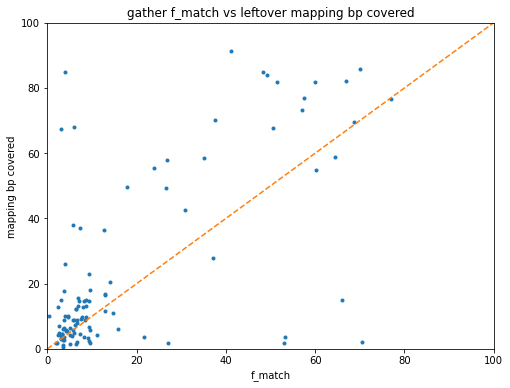

In [7]:
pylab.figure(num=None, figsize=(8, 6))
pylab.plot(gather_df["f_match"]* 100, 100 - left_df["percent missed"], '.')

pylab.xlim(0, 100)
pylab.ylim(0, 100)
pylab.xlabel('f_match')
pylab.ylabel('mapping bp covered')
pylab.title('gather f_match vs leftover mapping bp covered')
pylab.plot([0, 100], [0, 100], '--')

## fig 2: fraction of hashes unique to query, in order of gather results

Text(0, 0.5, 'f_unique_to_query, as %')

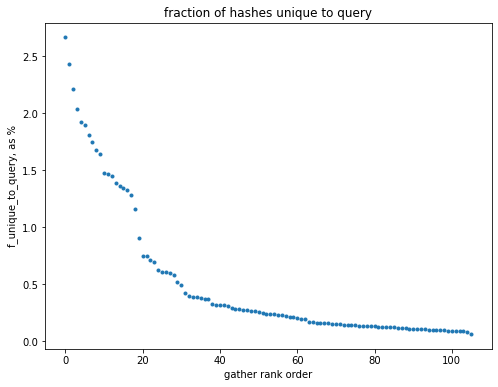

In [8]:
pylab.figure(num=None, figsize=(8, 6))
pylab.plot(gather_df.index, gather_df["f_unique_to_query"]*100, '.')

pylab.title('fraction of hashes unique to query')
pylab.xlabel('gather rank order')
pylab.ylabel('f_unique_to_query, as %')

## fig 4: sum mapped bp and sum identified hashes, in order of gather

conclusion: across the gather run, total hashes identified correlate well with total bp mapped

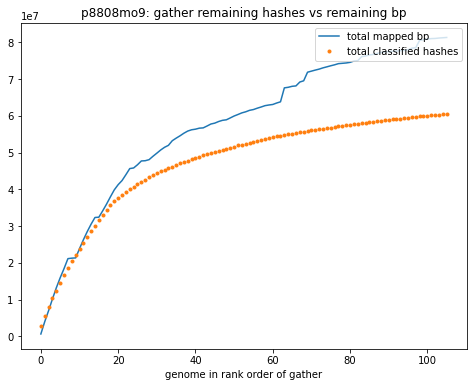

In [9]:
pylab.figure(num=None, figsize=(8, 6))
pylab.plot(left_df.index, left_df["mapped_bp"].cumsum(), '-', label='total mapped bp')
pylab.plot(gather_df.index, gather_df["unique_intersect_bp"].cumsum(), '.', label='total classified hashes')

pylab.xlabel('genome in rank order of gather')
pylab.legend(loc='upper right')
pylab.title(f'{sample_id}: gather remaining hashes vs remaining bp')
pylab.savefig(f'/tmp/gather-{sample_id}.pdf')

## fig 5: mapped bp and identified hashes compared by sample, in order of gather

conclusion: for most samples, bp mapped to that genome matches # of hashes classified to that genome

note: hashes classified to this genome is monotonically decreasing, b/c gather is a greedy algorithm.

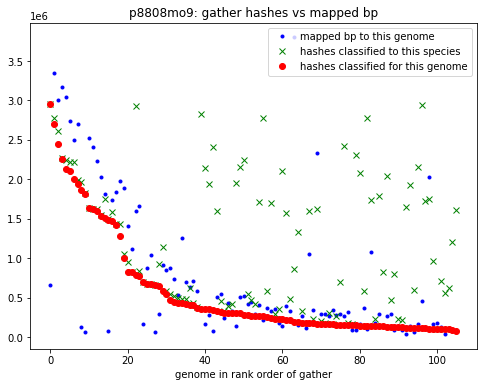

In [10]:
pylab.figure(num=None, figsize=(8, 6))

pylab.plot(left_df.index, left_df.mapped_bp, 'b.', label='mapped bp to this genome')
pylab.plot(gather_df.index, gather_df.intersect_bp, 'gx', label='hashes classified to this species')
pylab.plot(gather_df.index, gather_df.unique_intersect_bp, 'ro', label='hashes classified for this genome')

pylab.xlabel('genome in rank order of gather')
pylab.legend(loc='upper right')
pylab.title(f'{sample_id}: gather hashes vs mapped bp')
pylab.savefig(f'/tmp/gather-{sample_id}.pdf')

## fig 6: difference between hashes ident and bp mapped

Text(0, 0.5, 'difference: hashcount - mapped bp')

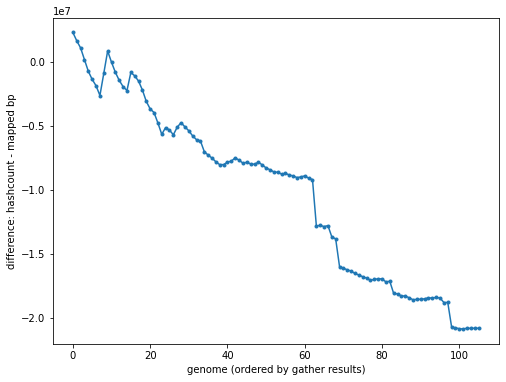

In [11]:
pylab.figure(num=None, figsize=(8, 6))
pylab.plot(gather_df.index, gather_df.unique_intersect_bp.cumsum() - left_df.mapped_bp.cumsum(), '.-')

pylab.xlabel('genome (ordered by gather results)')
pylab.ylabel('difference: hashcount - mapped bp')

## fig 7: difference between hashes and bp, per sample

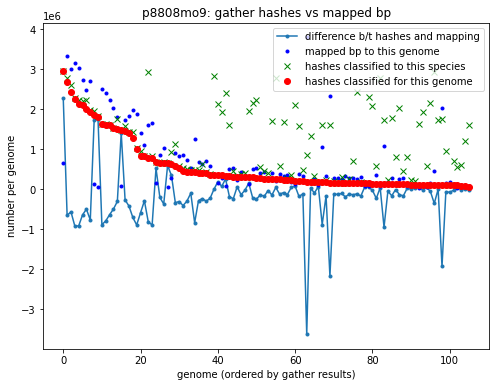

In [12]:
pylab.figure(num=None, figsize=(8, 6))
pylab.plot(gather_df.index, gather_df.unique_intersect_bp - left_df.mapped_bp, '.-', label='difference b/t hashes and mapping')

pylab.plot(left_df.index, left_df.mapped_bp, 'b.', label='mapped bp to this genome')
pylab.plot(gather_df.index, gather_df.intersect_bp, 'gx', label='hashes classified to this species')
pylab.plot(gather_df.index, gather_df.unique_intersect_bp, 'ro', label='hashes classified for this genome')

pylab.xlabel('genome (ordered by gather results)')
pylab.ylabel('number per genome')
pylab.legend(loc='upper right')
pylab.title(f'{sample_id}: gather hashes vs mapped bp')
pylab.savefig(f'/tmp/gatherdiff-{sample_id}.pdf')
pylab.savefig(f'/tmp/gatherdiff-{sample_id}.svg')